## 라이브러리 삽입

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
import sys
import gc
import pickle
from itertools import product
import os

from xgboost import XGBRegressor
from xgboost import plot_importance

In [2]:
test = pd.read_csv(os.getenv('HOME')+'/aiffel/kaggle_AIS3/test.csv')
train = pd.read_csv(os.getenv('HOME')+'/aiffel/kaggle_AIS3/sales_train.csv')
shops = pd.read_csv(os.getenv('HOME')+'/aiffel/kaggle_AIS3/shops.csv')
items = pd.read_csv(os.getenv('HOME')+'/aiffel/kaggle_AIS3/items.csv')
cats = pd.read_csv(os.getenv('HOME')+'/aiffel/kaggle_AIS3/item_categories.csv')

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


## 이상치 제거

<AxesSubplot:xlabel='item_price'>

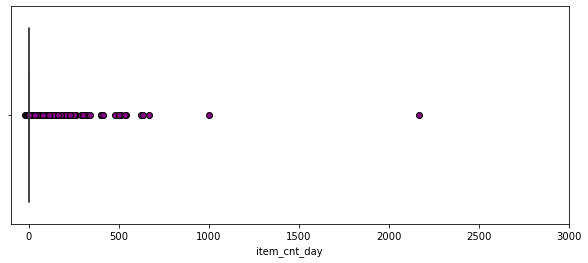

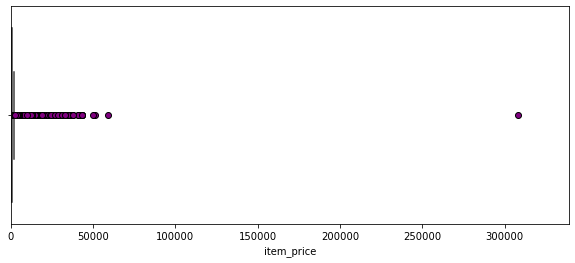

In [4]:
# 출처: Future Sales3
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

In [5]:
# 판매량과 가격의 이상치를 제거해 준다.
train = train[(train.item_price < 300000 )& (train.item_cnt_day < 1000)]

## shop 데이터 정리

In [6]:
# shops 이름 정리
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

In [7]:
# shop city column 추가
from sklearn.preprocessing import LabelEncoder
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_name", "shop_id", "shop_city"]]

## item category 데이터 정리

In [8]:

cats["main_cat_id"] = cats.item_category_name.str.split("-").map( lambda x: x[0] )
cats["main_cat_id"] = LabelEncoder().fit_transform( cats.main_cat_id )
cats = cats[["item_category_name", "item_category_id", "main_cat_id"]]

In [9]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# РостовНаДону ТРК "Мегацентр Горизонт"
train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [10]:
cats[0:20]

,item_category_name,item_category_id,main_cat_id
0,PC - Гарнитуры/Наушники,0,0
1,Аксессуары - PS2,1,1
2,Аксессуары - PS3,2,1
3,Аксессуары - PS4,3,1
4,Аксессуары - PSP,4,1
5,Аксессуары - PSVita,5,1
6,Аксессуары - XBOX 360,6,1
7,Аксессуары - XBOX ONE,7,1
8,Билеты (Цифра),8,2
9,Доставка товара,9,3


In [11]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [12]:
items = pd.merge(items, cats, on='item_category_id', how='left')

In [13]:
items=items.drop('item_category_name',axis=1)

In [14]:
items=items.drop('item_name',axis=1)

In [15]:
train=pd.merge(train,items, on ='item_id', how ='left')

In [31]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,main_cat_id
0,02.01.2013,0,59,22154,999.00,1.0,37,11
1,03.01.2013,0,25,2552,899.00,1.0,58,13
2,05.01.2013,0,25,2552,899.00,-1.0,58,13
3,06.01.2013,0,25,2554,1709.05,1.0,58,13
4,15.01.2013,0,25,2555,1099.00,1.0,56,13
...,...,...,...,...,...,...,...,...
2935841,10.10.2015,33,25,7409,299.00,1.0,55,13
2935842,09.10.2015,33,25,7460,299.00,1.0,55,13
2935843,14.10.2015,33,25,7459,349.00,1.0,55,13
2935844,22.10.2015,33,25,7440,299.00,1.0,57,13


In [50]:
monthly_sales1=train.groupby(["date_block_num","shop_id","item_id","item_category_id","main_cat_id"])[
    "item_price","item_cnt_day"].agg({"item_price":"mean","item_cnt_day":"sum"})

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [51]:
monthly_sales1

item_price  \
date_block_num shop_id item_id item_category_id main_cat_id               
0              2       27      19               5                2499.0   
                       33      37               11                499.0   
                       317     45               12                299.0   
                       438     45               12                299.0   
                       471     49               12                399.0   
...                                                                 ...   
33             59      22087   83               20                119.0   
                       22088   83               20                119.0   
                       22091   83               20                179.0   
                       22100   42               12                629.0   
                       22102   42               12               1250.0   

                                                             item_cnt_day  
date_block_num shop_id item_id item_category_id main_cat_id                
0              2       27      19               5                     1.0  
                       33      37               11                    1.0  
                       317     45               12                    1.0  
                       438     45               12                    1.0  
                       471     49               12                    2.0  
...                                                                   ...  
33             59      22087   83               20                    6.0  
                       22088   83               20                    2.0  
                       22091   83               20                    1.0  
                       22100   42               12                    1.0  
                       22102   42               12                    1.0  

[1608270 rows x 2 columns]

In [55]:
monthly_sales1=train.groupby(["date_block_num","shop_id","item_id","item_category_id","main_cat_id"])["item_cnt_day"].sum()

In [57]:
ms = pd.DataFrame(monthly_sales1)

In [58]:
ms

item_cnt_day
date_block_num shop_id item_id item_category_id main_cat_id              
0              2       27      19               5                     1.0
                       33      37               11                    1.0
                       317     45               12                    1.0
                       438     45               12                    1.0
                       471     49               12                    2.0
...                                                                   ...
33             59      22087   83               20                    6.0
                       22088   83               20                    2.0
                       22091   83               20                    1.0
                       22100   42               12                    1.0
                       22102   42               12                    1.0

[1608270 rows x 1 columns]

In [33]:
monthly_sales2=train.groupby(["date_block_num","shop_id","main_cat_id",])[
    "item_price","item_cnt_day"].agg({"item_price":"mean","item_cnt_day":"sum"})

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [34]:
monthly_sales2.head(20)

item_price  item_cnt_day
date_block_num shop_id main_cat_id                            
0              2       1             1672.951356          66.0
                       4            12058.394737          20.0
                       5             1392.691043         240.0
                       8              485.297026         263.0
                       9             1665.666667           3.0
                       11             365.109146         248.0
                       12             326.185185          27.0
                       13             268.821429          56.0
                       14             621.953804         102.0
                       15            1098.527848          88.0
                       16              99.000000           1.0
                       19              37.500000          22.0
                       20              90.833333          10.0
               3       1             1216.056875          32.0
                       4            11650.340000           5.0
                       5             1376.851139         159.0
                       8              442.337553         246.0
                       9             1399.333333           3.0
                       11             359.825291         213.0
                       13             347.414634          82.0

In [22]:
monthly_sales3=train.groupby(["date_block_num","shop_id"])[
    "item_price","item_cnt_day"].agg({"item_price":"mean","item_cnt_day":"sum"})

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [23]:
monthly_sales3

item_price  item_cnt_day
date_block_num shop_id                           
0              2         960.654952        1146.0
               3         734.329786         767.0
               4         702.325446        2114.0
               6         755.732835        3686.0
               7         749.145830        2495.0
...                             ...           ...
33             55        751.103833        1972.0
               56       1089.635193        1263.0
               57       1061.750358        2316.0
               58       1211.920188        1446.0
               59       1129.254066         790.0

[1575 rows x 2 columns]

In [26]:
monthly_sales4=train.groupby(["date_block_num"])[
    "item_cnt_day"].sum()

In [27]:
monthly_sales4

date_block_num
0     131479.0
1     128090.0
2     147142.0
3     107190.0
4     106970.0
5     125381.0
6     116966.0
7     125291.0
8     133332.0
9     127541.0
10    130009.0
11    183341.0
12    116899.0
13    109687.0
14    115297.0
15     96556.0
16     97790.0
17     97429.0
18     91280.0
19    102721.0
20     99208.0
21    107422.0
22    117845.0
23    168755.0
24    109971.0
25     84198.0
26     82014.0
27     77827.0
28     72295.0
29     64114.0
30     63187.0
31     66079.0
32     72843.0
33     68887.0
Name: item_cnt_day, dtype: float64

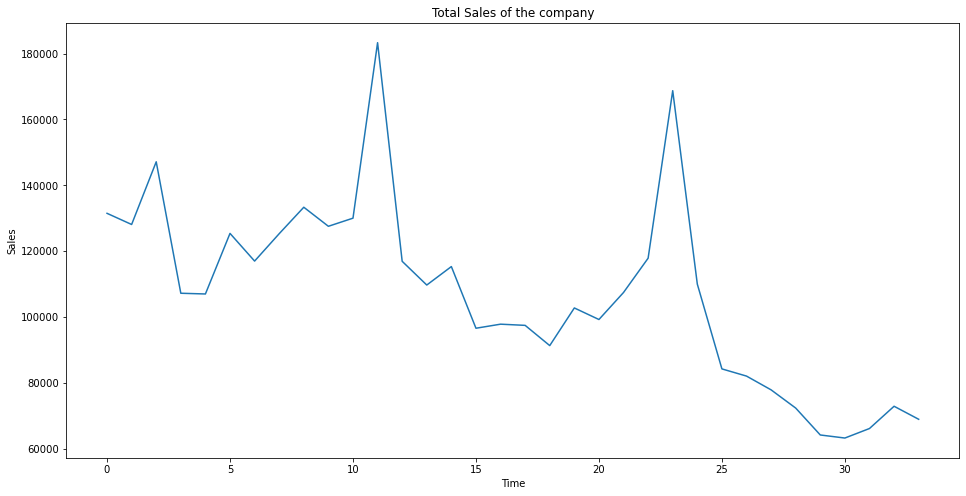

In [28]:
monthly_sales4.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(monthly_sales4);

In [33]:
# shop_id_list=list(set(train.shop_id))

In [34]:
# shop_id_list

In [35]:
# sns.pairplot(df, 
#              hue = "species" # helps to separate the values by specios
#             );

In [36]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
